In [1]:
from joblib import Parallel, delayed
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.dummy import DummyRegressor
from utils import *

In [2]:
def append_pairwise_error(df):
    df["pairwise_error"] = 0
    counter = 0
    for algo1 in algorithms:
        for algo2 in algorithms:
            if algo1 != algo2:
                pair_error = ((df[f'{algo1}_pred'] < df[f'{algo2}_pred']) != (df[f'{algo1}_true'] < df[f'{algo2}_true'])).astype(int)
                df["pairwise_error"] += pair_error
                counter += 1
    df["pairwise_error"] /= counter
    return df

In [3]:
algorithms = ['GA', 'PSO', 'DE', 'CMAES', 'ES']
meta_columns = ['problem1', 'problem2', 'instance1', 'instance2', 'alpha', 'dim', 'algorithm_run']
meta_columns_no_run = ['problem1', 'problem2', 'instance1', 'instance2', 'alpha', 'dim']

In [4]:
dfxgb = pd.read_csv("pred_all_functions_xgboost.csv", index_col=False)
dfdummy = pd.read_csv("pred_all_functions_dummy.csv", index_col=False)

In [5]:
dfdummy

,problem1,problem2,instance1,instance2,alpha,dim,GA_true,PSO_true,DE_true,CMAES_true,ES_true,GA_pred,PSO_pred,DE_pred,CMAES_pred,ES_pred
0,1,1,1,1,0.0,5,5.000000,1.833333,1.833333,2.333333,4.000000,3.873713,2.978268,3.057025,2.180626,2.910367
1,1,1,1,1,0.0,5,5.000000,1.833333,1.833333,2.333333,4.000000,3.873713,2.978268,3.057025,2.180626,2.910367
2,1,1,1,1,0.0,5,5.000000,1.833333,1.833333,2.333333,4.000000,3.873713,2.978268,3.057025,2.180626,2.910367
3,1,1,1,1,0.0,5,5.000000,1.833333,1.833333,2.333333,4.000000,3.873713,2.978268,3.057025,2.180626,2.910367
4,1,1,1,1,0.0,5,5.000000,1.833333,1.833333,2.333333,4.000000,3.873713,2.978268,3.057025,2.180626,2.910367
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3801595,24,24,4,4,1.0,5,3.633333,2.300000,3.033333,1.600000,4.433333,3.873713,2.978268,3.057025,2.180626,2.910367
3801596,24,24,4,4,1.0,5,3.633333,2.300000,3.033333,1.600000,4.433333,3.873713,2.978268,3.057025,2.180626,2.910367
3801597,24,24,4,4,1.0,5,3.633333,2.300000,3.033333,1.600000,4.433333,3.873713,2.978268,3.057025,2.180626,2.910367
3801598,24,24,4,4,1.0,5,3.633333,2.300000,3.033333,1.600000,4.433333,3.873713,2.978268,3.057025,2.180626,2.910367


In [6]:
dfrandom = dfdummy.copy()
for a in algorithms:
    dfrandom[f'{a}_pred'] = np.random.rand(len(dfdummy))

In [7]:
dfrandom

,problem1,problem2,instance1,instance2,alpha,dim,GA_true,PSO_true,DE_true,CMAES_true,ES_true,GA_pred,PSO_pred,DE_pred,CMAES_pred,ES_pred
0,1,1,1,1,0.0,5,5.000000,1.833333,1.833333,2.333333,4.000000,0.120843,0.504812,0.424009,0.439127,0.937035
1,1,1,1,1,0.0,5,5.000000,1.833333,1.833333,2.333333,4.000000,0.575783,0.076008,0.276389,0.751694,0.354327
2,1,1,1,1,0.0,5,5.000000,1.833333,1.833333,2.333333,4.000000,0.201631,0.949234,0.847982,0.001753,0.311382
3,1,1,1,1,0.0,5,5.000000,1.833333,1.833333,2.333333,4.000000,0.144350,0.742929,0.986054,0.339413,0.207030
4,1,1,1,1,0.0,5,5.000000,1.833333,1.833333,2.333333,4.000000,0.492913,0.235257,0.024659,0.888085,0.030981
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3801595,24,24,4,4,1.0,5,3.633333,2.300000,3.033333,1.600000,4.433333,0.366192,0.336264,0.794204,0.115917,0.658204
3801596,24,24,4,4,1.0,5,3.633333,2.300000,3.033333,1.600000,4.433333,0.556198,0.246283,0.964201,0.593481,0.354540
3801597,24,24,4,4,1.0,5,3.633333,2.300000,3.033333,1.600000,4.433333,0.261555,0.666157,0.988786,0.298427,0.719090
3801598,24,24,4,4,1.0,5,3.633333,2.300000,3.033333,1.600000,4.433333,0.006010,0.916372,0.072925,0.740989,0.958957


In [8]:
dfxgb = append_pairwise_error(dfxgb)
dfdummy = append_pairwise_error(dfdummy)
dfrandom = append_pairwise_error(dfrandom)

In [9]:
lw=3
xgb_label = 'XGBoost rank'
median_label = 'Mean rank'
random_label = 'Random rank'

y_lims = [-0.05, 0.55]

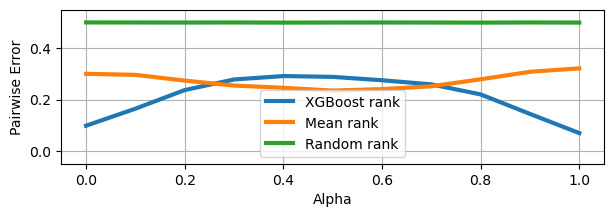

In [10]:
v1 = dfxgb.query('problem1!=problem2').groupby(['alpha']).mean().reset_index()
v2 = dfdummy.query('problem1!=problem2').groupby(['alpha']).mean().reset_index()
v3 = dfrandom.query('problem1!=problem2').groupby(['alpha']).mean().reset_index()

v4 = dfdummy.query('problem1==problem2').groupby(['alpha']).mean().reset_index()
v5 = dfxgb.query('problem1==problem2').groupby(['alpha']).mean().reset_index()

plt.figure(figsize=(7, 2))

# Plot the data
plt.plot(v1['alpha'], v1['pairwise_error'], label=xgb_label, lw=lw)
plt.plot(v2['alpha'], v2['pairwise_error'], label=median_label, lw=lw)
plt.plot(v3['alpha'], v3['pairwise_error'], label=random_label, lw=lw)

#plt.plot(v4['alpha'], v4['pairwise_error'], label='Dummy ==')
#plt.plot(v5['alpha'], v5['pairwise_error'], label='XGBoost ==')

plt.grid()
plt.legend()
plt.xlabel('Alpha')
plt.ylabel('Pairwise Error')
plt.ylim(y_lims)
plt.savefig(f'figures/accuracy_alphas.pdf', bbox_inches='tight', pad_inches=0)

6 4


Text(0, 0.5, 'Pairwise Error')

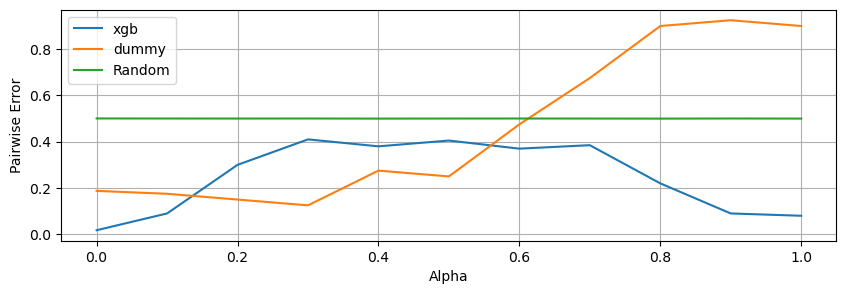

In [11]:
import random

p1 = random.randint(1, 24)
p2 = random.randint(1, 24)
print(p1, p2)
#p1 = 5
#p2 = 7

v1 = dfxgb.groupby(['problem1', 'problem2', 'alpha']).mean().reset_index().query(f'problem2=={p1} and problem1=={p2}')
v2 = dfdummy.groupby(['problem1', 'problem2', 'alpha']).mean().reset_index().query(f'problem2=={p1} and problem1=={p2}')

plt.figure(figsize=(10, 3))

plt.plot(v1['alpha'], v1['pairwise_error'], label='xgb')
plt.plot(v2['alpha'], v2['pairwise_error'], label='dummy')
plt.plot(v3['alpha'], v3['pairwise_error'], label='Random')

plt.grid()
plt.legend()
plt.xlabel('Alpha')
plt.ylabel('Pairwise Error')
#plt.ylim([-0.05, 0.85])

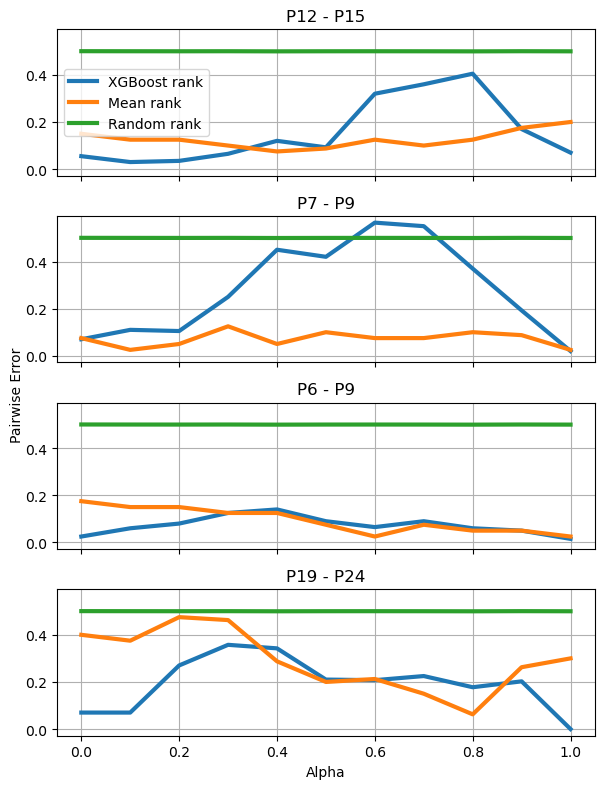

In [12]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(4, 1, figsize=(6, 8), sharex=True, sharey=True)

p1 = 12
p2 = 15

v1 = dfxgb.groupby(['problem1', 'problem2', 'alpha']).mean().reset_index().query(f'problem2=={p1} and problem1=={p2}')
v2 = dfdummy.groupby(['problem1', 'problem2', 'alpha']).mean().reset_index().query(f'problem2=={p1} and problem1=={p2}')
axes[0].plot(v1['alpha'], v1['pairwise_error'], label=xgb_label, lw=lw)
axes[0].plot(v2['alpha'], v2['pairwise_error'], label=median_label, lw=lw)
axes[0].plot(v3['alpha'], v3['pairwise_error'], label=random_label, lw=lw)
axes[0].grid()
axes[0].set_title(f'P{p1} - P{p2}')

p1 = 19
p2 = 24
v1 = dfxgb.groupby(['problem1', 'problem2', 'alpha']).mean().reset_index().query(f'problem2=={p1} and problem1=={p2}')
v2 = dfdummy.groupby(['problem1', 'problem2', 'alpha']).mean().reset_index().query(f'problem2=={p1} and problem1=={p2}')
axes[3].plot(v1['alpha'], v1['pairwise_error'], label=xgb_label, lw=lw)
axes[3].plot(v2['alpha'], v2['pairwise_error'], label=median_label, lw=lw)
axes[3].plot(v3['alpha'], v3['pairwise_error'], label=random_label, lw=lw)
axes[3].grid()
axes[3].set_title(f'P{p1} - P{p2}')

p1 = 7
p2 = 9
v1 = dfxgb.groupby(['problem1', 'problem2', 'alpha']).mean().reset_index().query(f'problem2=={p1} and problem1=={p2}')
v2 = dfdummy.groupby(['problem1', 'problem2', 'alpha']).mean().reset_index().query(f'problem2=={p1} and problem1=={p2}')
axes[1].plot(v1['alpha'], v1['pairwise_error'], label=xgb_label, lw=lw)
axes[1].plot(v2['alpha'], v2['pairwise_error'], label=median_label, lw=lw)
axes[1].plot(v3['alpha'], v3['pairwise_error'], label=random_label, lw=lw)
axes[1].grid()
axes[1].set_title(f'P{p1} - P{p2}')

p1 = 6
p2 = 9
v1 = dfxgb.groupby(['problem1', 'problem2', 'alpha']).mean().reset_index().query(f'problem2=={p1} and problem1=={p2}')
v2 = dfdummy.groupby(['problem1', 'problem2', 'alpha']).mean().reset_index().query(f'problem2=={p1} and problem1=={p2}')
axes[2].plot(v1['alpha'], v1['pairwise_error'], label=xgb_label, lw=lw)
axes[2].plot(v2['alpha'], v2['pairwise_error'], label=median_label, lw=lw)
axes[2].plot(v3['alpha'], v3['pairwise_error'], label=random_label, lw=lw)
axes[2].grid()
axes[2].set_title(f'P{p1} - P{p2}')

axes[0].legend()

axes[-1].set_xlabel("Alpha")
fig.text(0.00, 0.5, "Pairwise Error", va='center', rotation='vertical')

plt.tight_layout()
plt.savefig(f'figures/accuracy_alphas_examples.pdf', bbox_inches='tight', pad_inches=0)

In [32]:
df = pd.DataFrame({'problem1': [],
 'problem2': [1],
 'instance1': [1],
 'instance2': [1],
 'alpha': [1],
 'dim': [1],
 'GA_true': [5],
 'PSO_true': [2.33],
 'DE_true': [2.67],
 'CMAES_true': [1],
 'ES_true': [4],
 'GA_pred': [4.8],
 'PSO_pred': [2.63],
 'DE_pred': [2.37],
 'CMAES_pred': [1.1],
 'ES_pred': [4.1],})
df

ValueError: All arrays must be of the same length

In [23]:
l = append_pairwise_error(dfxgb.copy())

In [24]:
l

,problem1,problem2,instance1,instance2,alpha,dim,GA_true,PSO_true,DE_true,CMAES_true,ES_true,GA_pred,PSO_pred,DE_pred,CMAES_pred,ES_pred,pairwise_error
0,1,1,1,1,0.0,5,5.000000,1.833333,1.833333,2.333333,4.000000,4.904065,1.599649,1.601849,2.745491,3.994673,0.05
1,1,1,1,1,0.0,5,5.000000,1.833333,1.833333,2.333333,4.000000,4.911806,1.646655,1.815701,2.470135,4.004593,0.05
2,1,1,1,1,0.0,5,5.000000,1.833333,1.833333,2.333333,4.000000,4.960050,1.632111,1.585295,2.693161,4.016370,0.05
3,1,1,1,1,0.0,5,5.000000,1.833333,1.833333,2.333333,4.000000,4.958959,1.567263,1.636367,2.557899,3.981420,0.05
4,1,1,1,1,0.0,5,5.000000,1.833333,1.833333,2.333333,4.000000,4.988667,1.555082,1.596088,2.715716,3.993584,0.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3801595,24,24,4,4,1.0,5,3.633333,2.300000,3.033333,1.600000,4.433333,3.720942,2.333660,3.018026,1.642423,4.282139,0.00
3801596,24,24,4,4,1.0,5,3.633333,2.300000,3.033333,1.600000,4.433333,3.705573,2.359373,2.949833,1.654958,4.253513,0.00
3801597,24,24,4,4,1.0,5,3.633333,2.300000,3.033333,1.600000,4.433333,3.527666,2.422326,3.062169,1.624213,4.242671,0.00
3801598,24,24,4,4,1.0,5,3.633333,2.300000,3.033333,1.600000,4.433333,3.702152,2.357915,3.084923,1.632747,4.288418,0.00


In [29]:
{x:[] for x in list(l.columns)}

{'problem1': [],
 'problem2': [],
 'instance1': [],
 'instance2': [],
 'alpha': [],
 'dim': [],
 'GA_true': [],
 'PSO_true': [],
 'DE_true': [],
 'CMAES_true': [],
 'ES_true': [],
 'GA_pred': [],
 'PSO_pred': [],
 'DE_pred': [],
 'CMAES_pred': [],
 'ES_pred': [],
 'pairwise_error': []}